In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from sag import SAG
from saga import SAGA
from sag_adam import SAG_adam
from saga_adam import SAGA_adam
from saga_mb import SAGA_mb
from torch.optim.optimizer import Optimizer, required
import torch.optim as optim
from torch.optim import lr_scheduler
from helpers import *
import time
import math
from resnet import ResNet18
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, sampler
import os
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [3]:
N_CLUSTERS = 1
MOMENTUM_SAGA = 0.1
MOMENTUM_SGD = 0.9
N_SAMPLES = 50000
betas = (0.9,0.999)
BATCH_SIZE = 1
lr_schedule = False
lr = 0.0001
n_epochs = 1000
opti = "Adam"
freeze = False
pretrained = False
centered = "centered"
OUT_DIM = 10

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=32,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [6]:
testiter = iter(testloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [7]:
model_SGD_MB = models.resnet18(pretrained=pretrained)
if (freeze):
    for param in model_SGD_MB.parameters():
        param.requires_grad = False
n_features = model_SGD_MB.fc.in_features
model_SGD_MB.fc = nn.Linear(n_features, OUT_DIM)
model_SGD_MB = model_SGD_MB.to(device)


model_SGD = models.resnet18(pretrained=pretrained)
if (freeze):
    for param in model_SGD.parameters():
        param.requires_grad = False
n_features = model_SGD.fc.in_features
model_SGD.fc = nn.Linear(n_features, OUT_DIM)
model_SGD = model_SGD.to(device)

model_SAGA = models.resnet18(pretrained=pretrained)
if (freeze):
    for param in model_SAGA.parameters():
        param.requires_grad = False
n_features = model_SAGA.fc.in_features
model_SAGA.fc = nn.Linear(n_features, OUT_DIM)
model_SAGA = model_SAGA.to(device)

model_SAGA_2 = models.resnet18(pretrained=pretrained)
n_features = model_SAGA_2.fc.in_features
model_SAGA_2.fc = nn.Linear(n_features, OUT_DIM)
model_SAGA_2 = model_SAGA_2.to(device)

In [8]:
model_SGD_MB_losses = []
model_SGD_MB_test_e = []
model_SGD_losses = []
model_SGD_test_e = []
model_SAGA_losses = []
model_SAGA_test_e = []
model_SAGA_2_losses = []
model_SAGA_2_test_e = []


criterion = nn.CrossEntropyLoss()
if (opti == "Adam"):
    optimizer_SGD = torch.optim.Adam(model_SGD.parameters(), lr = lr, betas = betas)
    optimizer_SAGA = SAG_adam(model_SAGA.parameters(),n_classes=OUT_DIM, lr = lr,
                          class_proba = None,momentum=MOMENTUM_SAGA,compute_var = True,betas = betas)
    optimizer_SAGA_1 = torch.optim.Adam(list(model_SAGA_2.parameters())[:-2], lr = lr,betas=betas)
    optimizer_SAGA_2 = SAG_adam(list(model_SAGA_2.parameters())[-2:], n_classes=OUT_DIM, lr = lr,
                          class_proba = None,momentum=MOMENTUM_SAGA,compute_var = True,betas = betas)
else:
    optimizer_SGD_MB = torch.optim.SGD(model_SGD_MB.parameters(), lr = lr,momentum=MOMENTUM_SGD)
    optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr = lr,momentum=MOMENTUM_SGD)
#     if (lr_schedule):
#         optimizer_SGD = SGD(model_SGD.parameters(), lr = lr,momentum=betas[0],lr_schedule = True)
#         optimizer_SGD_MB = SGD(model_SGD_MB.parameters(), lr = lr,momentum=betas[0],lr_schedule = True)
    optimizer_SAGA = SAG(model_SAGA.parameters(), n_classes=OUT_DIM, lr = lr, lr_schedule= lr_schedule,
                          class_proba = None,momentum=MOMENTUM_SAGA,compute_var = True,beta1 = MOMENTUM_SGD)
    optimizer_SAGA_1 = torch.optim.SGD(list(model_SAGA_2.parameters())[:-2], lr = lr,momentum=MOMENTUM_SGD)
    optimizer_SAGA_2 = SAG(list(model_SAGA_2.parameters())[-2:], n_classes=OUT_DIM, lr = lr,
                          class_proba = None,momentum=MOMENTUM_SAGA,compute_var = True,beta1 = MOMENTUM_SGD)

In [9]:
def compute_error(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images.to(device)).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

In [10]:
# def compute_error(model,X,y):
#     e = 0
#     #Probably smarter way to compute the error; the value 50 was chosen because higher caused memory issues
#     for i in range(int(X.shape[0]/50)):
#         pred = model.forward(torch.Tensor(X_test[i*50:(i+1)*50]).to(device))
#         pred = (torch.max(pred.data,1)[1]).cpu().numpy()
#         err = (y[i*50:(i+1)*50] != pred)
#         e += err.sum()
#     return e/X.shape[0]

In [11]:
# tstart = time.process_time()
# compute_error(model_SAGA_2,X_test,y_test)
# print('SGD Elapsed time: {:.2f}s'.format(time.process_time() - tstart))

In [12]:
#train SGD MB
tstart = time.process_time()
SGD_MB_avg_var = []
SGD_MB_var = 0
total_loss = 0

i = 0
    
# for epoch in range(n_epochs):
#     for inputs, labels in trainloader2:
#         outputs = model_SGD_MB.forward(inputs.to(device))
#         loss = criterion(outputs, labels.to(device))
#         loss.backward()
#         total_loss += loss.data.item()
#         model_SGD_MB_losses.append(total_loss/(i+1))
#         optimizer_SGD_MB.step()
#         for param_group in list(model_SGD_MB.parameters()):
#             SGD_MB_var += (param_group.grad.data**2).sum()
#         SGD_MB_avg_var.append(SGD_MB_var.cpu().numpy()/(i+1))
# #         if (epoch % 1000 == 0):
# #             e = compute_error(model_SGD,X_test,y_test)
# #             model_SGD_test_e.append(e)
#         optimizer_SGD_MB.zero_grad()
#         i+= 1
#         if i == n_epochs:
#             break
#     if i == n_epochs:
#         break
print('SGD Elapsed time: {:.2f}s'.format(time.process_time() - tstart))

SGD Elapsed time: 0.00s


In [13]:
#train SGD
tstart = time.process_time()
SGD_avg_var = []
SGD_var = 0
total_loss = 0

i = 0
    
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        outputs = model_SGD.forward(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        total_loss += loss.data.item()
        model_SGD_losses.append(total_loss/(i+1))
        optimizer_SGD.step()
        for param_group in list(model_SGD.parameters()):
            SGD_var += (param_group.grad.data**2).sum()
        SGD_avg_var.append(SGD_var.cpu().numpy()/(i+1))
#         if (epoch % 1000 == 0):
#             e = compute_error(model_SGD,X_test,y_test)
#             model_SGD_test_e.append(e)
        optimizer_SGD.zero_grad()
        i+= 1
        if i == n_epochs:
            break
    if i == n_epochs:
        break
print('SGD Elapsed time: {:.2f}s'.format(time.process_time() - tstart))

SGD Elapsed time: 1143.23s


In [14]:
#train SAGA
tstart = time.process_time()
SAGA_avg_var = []
SAGA_var = 0
total_loss = 0
i = 0

for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        outputs = model_SAGA.forward(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        total_loss += loss.data.item()
        model_SAGA_losses.append(total_loss/(i+1))
        closure = labels
        _,var = optimizer_SAGA.step(closure)
        SAGA_var += var
        SAGA_avg_var.append(SAGA_var.cpu().numpy()/(i+1))
#         if (epoch % 1000 == 0):
#             e = compute_error(model_SAGA,X_test,y_test)
#             model_SAGA_test_e.append(e)
        optimizer_SAGA.zero_grad()
        i+= 1
        if i == n_epochs:
            break
    if i == n_epochs:
        break
print('SAGA Elapsed time: {:.2f}s'.format(time.process_time() - tstart))

SAGA Elapsed time: 2221.16s


In [15]:
#train SAGA with 2 optimizers
tstart = time.process_time()
SAGA_2_avg_var = []
SAGA_2_var = 0
total_loss = 0
i = 0

for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        outputs = model_SAGA_2.forward(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        total_loss += loss.data.item()
        model_SAGA_2_losses.append(total_loss/(i+1))
        closure = labels
        
        optimizer_SAGA_1.step()
        for param_group in list(model_SAGA_2.parameters())[:-2]:
            SAGA_2_var += (param_group.grad.data**2).sum()
        
        _, var_2 = optimizer_SAGA_2.step(closure)
        SAGA_2_var += var_2
        SAGA_2_avg_var.append(SAGA_2_var.cpu().numpy()/(i+1))
#         if (epoch % 1000 == 0):
#             e = compute_error(model_SAGA_2,X_test,y_test)
#             model_SAGA_2_test_e.append(e)
        optimizer_SAGA_1.zero_grad()
        optimizer_SAGA_2.zero_grad()
        i+= 1
        if i == n_epochs:
            break
    if i == n_epochs:
        break

print('SAGA 2 optimizers Elapsed time: {:.2f}s'.format(time.process_time() - tstart))

SAGA 2 optimizers Elapsed time: 1231.48s


In [16]:
def plot_val(losses, labels,val = "loss"):
    plt.figure(figsize=(15,5))
    for losses, label in zip(losses, labels):
        plt.plot(losses, label = label)
    plt.legend(loc='upper right')
    plt.title('ResNet cifar10 {} (freeze = {}, pretrained = {}, {}) (lr: {}, n_samples = {}, betas: {})'.format(centered,
                                                                                            freeze, pretrained,
                                                                                          opti,lr,N_SAMPLES,betas))
    plt.xlabel('iteration')
    plt.ylabel(val)

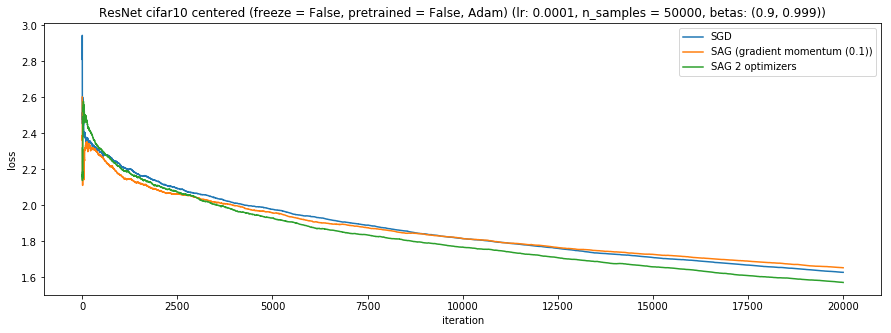

In [17]:
plot_val([model_SGD_losses,model_SAGA_losses,model_SAGA_2_losses],
         ['SGD','SAG (gradient momentum ({}))'.format(MOMENTUM_SAGA),
          'SAG 2 optimizers'])

In [18]:
# def plot_val(losses, labels,val = "loss"):
#     plt.figure(figsize=(15,5))
#     for losses, label in zip(losses, labels):
#         plt.plot(losses, label = label)
#     plt.legend(loc='upper right')
#     plt.title('ResNet cifar10 {} (class,{}) (lr: {}, n_samples = {}, betas: {})'.format(centered,
#                                                                                           opti,lr,N_SAMPLES,betas))
#     plt.xlabel('iteration')
#     #plt.ylim(0,100)
#     plt.ylabel(val)

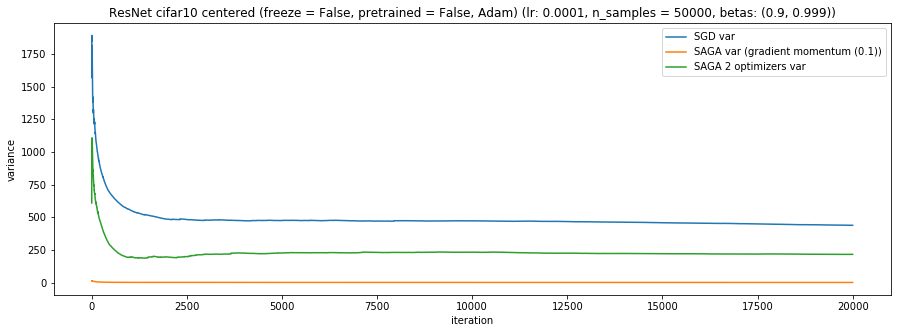

In [19]:
plot_val([SGD_avg_var,SAGA_avg_var,SAGA_2_avg_var],
         ['SGD var','SAGA var (gradient momentum ({}))'.format(MOMENTUM_SAGA),'SAGA 2 optimizers var'],"variance")

In [20]:
# def plot_err(losses, labels,val = "Error"):
#     plt.figure(figsize=(6,6))
#     for losses, label in zip(losses, labels):
#         plt.plot(losses, label = label)
#     plt.legend(loc='upper right')
#     plt.xlabel('Iteration (k)',fontsize = 25)
#     plt.xticks(fontsize=13)
#     plt.yticks(fontsize=13)
#     plt.ylabel(val,fontsize = 25)
#     #plt.ylim(50, 300)

In [21]:
# plot_err([model_SGD_test_e,model_SAGA_test_e,model_SAGA_2_test_e],
#          ['SGD','SAGApc(1)','SGD + SAGApc(1)'])

In [22]:
# from torchsummary import summary
# summary(model_SAGA, input_size=(3,32,32))